# practicalMixGaussC

The goal of this part of the lab is to fit a mixture of gaussians model to some multi-dimensional data. To do this, we will first generate some data from a known mixture of gaussians model and fit our own mixture of gaussians model to the generated data. The parameters from our estimated mixture of gaussians model should roughly match those of the original known model. 

Note that you should not use multivariate_normal.pdf for calculating likelihood.

You should use this template for your code and fill in the missing 
sections marked "TO DO."



In [119]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
from scipy.stats import norm 
import time
import sys

flt_min = sys.float_info.min

%matplotlib notebook

All the functions i implemented here were initially been created in a non vectorized form. In order to run more efficiently the Apple epxeriment part, I vectorized them. I present here both the two versions but i use the vectorised one for the current and the apple part.

In [120]:
## multivariate gauusian distribution implementatio in a vectorized and not vectorized format

In [121]:
def multivariate_gaussian_probability_vectorized(data, mean, covariance):
    data = data - mean[:, None]
    return np.power(np.linalg.det(2 * np.pi * covariance),-1/2) * np.exp(-1/2*(data.T.dot(np.linalg.inv(covariance)) * data.T).sum(1))

In [122]:
def multivariate_gaussian_probability(data, mean, covariance):
    
    ## transform my datum
    
    d = []
    m = []
    for i in range(len(data)):
        d.append([data[i]])
        m.append([mean[i]])
        
    mean = np.array(mean)
    data = np.array(data)
        
    return float((1/(((2* np.pi)**(len(mean)/2))*(np.linalg.det(covariance)**(1/2))))*np.exp((-1/2)*((data-mean).T.dot(np.linalg.inv(covariance))).dot((data-mean))))

## Construct Ground Truth Mixture of Gaussians Model and Plot Some Points

Define some true parameters for our ground truth mixture of $k$ Gaussians model. We will represent the 
mixtures of Gaussians as a python dictionary. The mean field is a $d \times k$ matrix and the cov field is a 
$d \times d \times k$ matrix.

In [124]:
mixGaussTrue = dict()
mixGaussTrue['k'] = 3
mixGaussTrue['d'] = 2
mixGaussTrue['weight'] = np.array([0.1309, 0.3966, 0.4725])
mixGaussTrue['mean'] = np.array([[ 4.0491 , 4.8597],[ 7.7578 , 1.6335],[ 11.9945, 8.9206]]).T
mixGaussTrue['cov'] = np.reshape([0.5, 0.25], newshape=(1,1,2))
mixGaussTrue['cov'] = np.zeros(shape=(mixGaussTrue['d'],mixGaussTrue['d'],mixGaussTrue['k']))
mixGaussTrue['cov'][:,:,0] = np.array([[  4.2534, 0.4791], [0.4791, 0.3522]])
mixGaussTrue['cov'][:,:,1] = np.array([[  0.9729, 0.8723],[  0.8723,  2.6317]])
mixGaussTrue['cov'][:,:,2] = np.array([[  0.9886, -1.2244],[ -1.2244, 3.0187]])

**drawEMData2d**, **sampleFromDiscrete**, **getGaussian2SD**, and **drawGaussianOutline** are helper functions.

In [125]:
def sampleFromDiscrete(probDist):     
    """
    Draws a random sample from a discrete probability distribution using a rejection sampling method.  
    
    Keyword arguments:
    probDist -- discrete probability ditrubtion to sample from.
    
    Returns: 
    r -- sampled point.
    """
    nIndex = len(probDist)                                                                 
    while True:                                                                            
        #choose random index                                                               
        r=int(np.floor(np.random.uniform()*nIndex))                                        
        #choose random height                                                              
        randHeight = np.random.uniform()                                                   
        #if height is less than probability value at this point in the                     
        # histogram then select                                                            
        if randHeight<probDist[r]:                                                         
            break                                                                          
    return r                                                                               

In [126]:
def getGaussian2SD(m,s,angle1):
    """
    Find position of in xy co-ordinates at 2SD out for a certain angle.
    """
  
    if s.shape[1] == 1:
        s = diag(s)

    vec = np.array([np.cos(angle1), np.sin(angle1)])
    
    factor = 4/(vec@np.linalg.inv(s)@vec.T)
    
    x = np.cos(angle1) * np.sqrt(factor)
    y = np.sin(angle1) * np.sqrt(factor)

    x = x + m[0]
    y = y + m[1]
                
    return x,y

In [127]:
def drawGaussianOutline(m,s,w):
    """
    Draw 2DGaussian
    """
    angleInc = 0.1    
    c = (0.9*(1-w), 0, 0)

    for cAngle in np.arange(0,2*np.pi,angleInc):         
        angle1 = cAngle
        angle2 = cAngle+angleInc
        x1, y1 = getGaussian2SD(m,s,angle1)
        x2, y2 = getGaussian2SD(m,s,angle2)
        plt.plot([x1, x2],[y1, y2],'-',linewidth=2,color=c)                 
    return

In [128]:
def drawEMData2d(data,mixGauss):
    """
    Plot the data plot the mixtures of Gaussian model, mixGauss, on top of it.
    
    Keyword arguments:
    data -- d by n matrix of data points.
    mixGauss -- dict with mixture of gaussian information.
    
    """
    #set(gcf,'Color',[1 1 1])
    plt.cla() 
    plt.plot(data[0,:],data[1,:],'k.')

    for cGauss in range(mixGauss['k']):
        drawGaussianOutline(mixGauss['mean'][:,cGauss],mixGauss['cov'][:,:,cGauss],mixGauss['weight'][cGauss])
    
    return     


**TODO H HERE:**

Complete the TO DO in this function before moving on.

Draw samples from a randomply chosen gaussian distribution similarly to part B. The only difference here is that we firstly sample from the covariance matrix using cholesky decomposition.

In [129]:
def mixGaussGen(mixGauss, nData):                                                                              
    """
    Generates data from a d-dimensional mixture of Gaussians model. 
    
    Keyword arguments:
    mixGauss -- dict containing the mixture of gaussians arguments.
    nData -- number of data points to generate.
    
    Returns: 
    data -- d by nData, generated data points. 
    
    """
    
    # create space for output data                                                                               
    data = np.zeros(shape=(mixGauss['d'], nData))
    
    # for each data point                                                                                        
    for cData in range(nData):                                                                                   
        # randomly choose Gaussian according to probability distributions                                        
        h = sampleFromDiscrete(mixGauss['weight'])     
        
        # draw a sample from the appropriate Gaussian distribution  
        # first sample from the covariance matrix (google how to do this - it
        # will involve the numpy function np.linalg.cholesky().  Then add the mean vector
        
        sampled_cov = np.linalg.cholesky(mixGaussTrue.get('cov')[:,:,h])
        
        data[:, cData] = mixGaussTrue.get('mean')[:,h] + sampled_cov@np.random.randn(2)
                                                                                                         
    return data

With all the helper functions complete, we can now generate and plot some points from our model. The black points are the generated data points. The circles are what the gaussians look like.

<IPython.core.display.Javascript object>


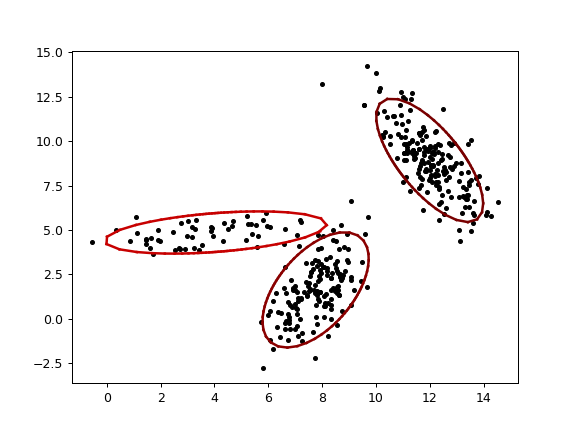

In [130]:
#define number of samples to generate
nData = 400;

#generate data from the mixture of Gaussians
#make sure you've filled in the routine above.
data = mixGaussGen(mixGaussTrue,nData)

#draw data, true Gaussians
drawEMData2d(data,mixGaussTrue)

The graph above illustrates the samples we draw from our ground truth distributions. These samples are going to be used in order to train our EM algorithm.

## Estimate MoG using the E-M Algorithm
Here we want to use the E-M algorithm to fit a MoG model to our data points. 

**TODO I HERE:** 

Fill out the missing parts below. 

The log likelihood is taken since the raw likelihood value could be too small for our machine's percision.

All the routines below were designed following the MoGCribSheet provided during the lab and presented the EM Algorith with Gaussian Mixtures Training.

In [131]:
def getMixGaussLogLike(data, mixGaussEst): 
   
    
    data = np.atleast_2d(data)                                                                         
    nDims, nData = data.shape                                                                          
    
    # initialize log likelihoods                                                                       
    logLike = 0                                                                                       
                                                                                                       
    # run through each data item                                                                       
    for cData in range(nData):                                                                         
        thisData = data[:, cData]                                                                      
       
        like = 0
        for k in range(0,mixGaussEst.get('k')):
            l = mixGaussEst.get('weight')[k]
            norm = multivariate_gaussian_probability(thisData, mixGaussTrue.get('mean')[:,k],  mixGaussTrue.get('cov')[:,:,k])
            like += l*norm   
        logLike = logLike + np.log(like)                                                               
                                                                                                       
    return  np.asscalar(logLike)                                                                       
                                                                                                       

In [132]:
## compute the log likelihood
def log_likelihood_vectorized(data, mixGaussEst):
       
    log_likelihoods = np.zeros((mixGaussEst['k'], data.shape[1]))

    for k in range(mixGaussEst['k']): 
        log_likelihoods[k, :] = mixGaussEst['weight'][k]*multivariate_gaussian_probability_vectorized(data, mixGaussEst['mean'][:, k], mixGaussEst['cov'][:, :,k])

    likelihood_sum = np.log(np.sum(log_likelihoods, axis=0))
    return np.asscalar(np.sum(likelihood_sum))


In [133]:
def E_step(responsibilities,mixGaussEst,data):
    
    curCov = mixGaussEst['cov']                                                                             
    curWeight = mixGaussEst['weight']                                                                            
    curMean = mixGaussEst['mean']
    
    l = np.zeros((mixGaussEst.get('k'),data.shape[1]),dtype=np.float64)
    r = np.zeros((mixGaussEst.get('k'),data.shape[1]),dtype=np.float64)
    
    i = -1
    for cData in range(data.shape[1]):
        i += 1
        
        thisData = data[:, cData] 
        
        sum_l = 0
        for k in range(0,mixGaussEst.get('k')):
            
            norm = multivariate_gaussian_probability(thisData.T, mixGaussTrue.get('mean')[:,k],  mixGaussTrue.get('cov')[:,:,k])
            ll = mixGaussEst.get('weight')[k]*norm
            
            l[k][i] = ll
            sum_l += l[k][i]
        
        for k in range(0,mixGaussEst.get('k')):
            r[k][i] = l[k][i]/sum_l
                                                                                                
    return r

In [134]:
# Expectation step
def E_step_vectorized(responsibilities,mixGaussEst,data):

    for k in range(mixGaussEst.get('k')):
        responsibilities[k, :] = mixGaussEst['weight'][k] * multivariate_gaussian_probability_vectorized(data, mixGaussEst['mean'][:, k], mixGaussEst['cov'][:, :, k])

    responsibilities /= np.sum(responsibilities, axis=0) + sys.float_info.min
            
    return responsibilities

In [135]:
## this function is not used
## takes the diagonal of a matrix and creates a matrix with the same diagonal
## and zero values in the other positions

In [136]:
def create_diagonal_covariance(cov):
    a_dim,b_dim = cov.shape
    new_cov = np.zeros((a_dim,b_dim),dtype=np.float64)
    diag = np.diagonal(cov)
    for i in range(0,a_dim):
        for j in range(0,b_dim):
            if(i==j):
                new_cov[i][j] = diag[i]
                
    return new_cov

In [137]:
def M_step(k,mixGaussEst,responsibilities,data):

                                                                               
    for cGauss in range(k):
        
        nDims, nData = data.shape
        
        
        new_m_matrix = np.zeros((1,nDims),dtype=np.float64)
        new_c_matrix = np.zeros((nDims,nDims),dtype=np.float64)

        ## update the weights
        r = 0
        for i in range(data.shape[1]):
            r += responsibilities[cGauss][i]
    
        sum_l = 0
        for kk in range(k):
            for ii in range(data.shape[1]):
                sum_l += responsibilities[kk][ii]
        
        mixGaussEst['weight'][cGauss] = r/sum_l
        
        ## update the mean
        i = -1
        for cData in range(data.shape[1]):
            i += 1
            
            thisData = data[:, cData]
            new_m_matrix = np.add(new_m_matrix,responsibilities[cGauss][i]*thisData)    
       
        new_m = new_m_matrix/r
        
        mixGaussEst.get('mean')[:,cGauss] = new_m
        
        ## update the covariance
        
        i = -1
        for cData in range(data.shape[1]):
            
            i += 1
            
            thisData = data[:, cData]
            
            new_mean = mixGaussTrue.get('mean')[:,cGauss]
            
            sub = np.subtract(thisData,new_mean)
            sub = sub.reshape(1,sub.shape[0])
            
            mu_matrix = sub.T@sub
            
            new_c_matrix = np.add(new_c_matrix,(responsibilities[cGauss][i]*mu_matrix))
        
        new_cov = new_c_matrix/r
        
        mixGaussEst['cov'][:,:,cGauss] = new_cov
            
    return mixGaussEst

In [138]:
def M_step_vectorized(responsibilities,mixGaussEst,data):
    
    responsibility = np.sum(responsibilities, axis=1)
       
    for k in range(mixGaussEst.get('k')):
                
        current_responsibility = responsibilities[k, :]
        
        ## update the weights
        mixGaussEst['weight'][k] = (np.sum(current_responsibility) / np.sum(responsibilities))
        ## update the mean
        mixGaussEst['mean'][:, k] = (data @ current_responsibility / np.sum(current_responsibility))
        ## update the covariance
        new_m = (data - mixGaussEst['mean'][:, k][:, None])
        mixGaussEst['cov'][:, :, k] = ((new_m * current_responsibility[None, :]) @ (new_m.T) / responsibility[k])
        
    return mixGaussEst

**TODO J HERE:** 

Fill out the missing parts below. 

In [139]:
VECTORIZED_VERSION = True

In [140]:
def fitMixGauss(data, k):
    """
    Estimate a k MoG model that would fit the data. Incremently plots the outcome.
               
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    k -- scalar representing the number of gaussians to use in the MoG model.
    
    Returns: 
    mixGaussEst -- dict containing the estimated MoG parameters.
    
    """
    
    #     MAIN E-M ROUTINE  
    #     In the E-M algorithm, we calculate a complete posterior distribution over                                  
    #     the (nData) hidden variables in the E-Step.  
    #     In the M-Step, we update the parameters of the Gaussians (mean, cov, w).   
    
    nDims, nData = data.shape


    postHidden = np.zeros(shape=(k, nData))

    # we will initialize the values to random values
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
        
    
    # calculate current likelihood
    # TO DO (j) starts here - fill in this routine
    
    logLike = None
    if (VECTORIZED_VERSION == False):
        logLike = getMixGaussLogLike(data, mixGaussEst)
    else:
        logLike = log_likelihood_vectorized(data, mixGaussEst)
        
    likelihood_list = [logLike]
    iterations = [0]

    nIter = 30

    logLikeVec = np.zeros(shape=(2 * nIter))
    boundVec = np.zeros(shape=(2 * nIter))

    fig, ax = plt.subplots(1, 1)

    for cIter in range(nIter):
        
        iterations.append(cIter + 1)

        # ===================== =====================
        # Expectation step
        # ===================== =====================
        
        # ===================== =====================
        # Maximization Step
        # ===================== =====================
        
        if (VECTORIZED_VERSION == False):
            postHidden = E_step(postHidden,mixGaussEst,data)
            mixGaussEst = M_step(k,mixGaussEst,postHidden,data)
        else:
            postHidden = E_step_vectorized(postHidden,mixGaussEst,data)
            mixGaussEst = mixGaussEst = M_step_vectorized(postHidden,mixGaussEst,data)

        # draw the new solution
        drawEMData2d(data, mixGaussEst)
        time.sleep(1)
        fig.canvas.draw()

        # calculate the log likelihood
        if (VECTORIZED_VERSION == False):
            logLike = getMixGaussLogLike(data, mixGaussEst)
        else:
            logLike = log_likelihood_vectorized(data, mixGaussEst)
        
        #print('Log Likelihood After Iter {} : {:4.3f}\n'.format(cIter, logLike))
        
        likelihood_list.append(logLike)

    return mixGaussEst,iterations,likelihood_list

### Time to put it all together!

Make sure you've filled all the TO DOs above! 

/home/apostolos/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


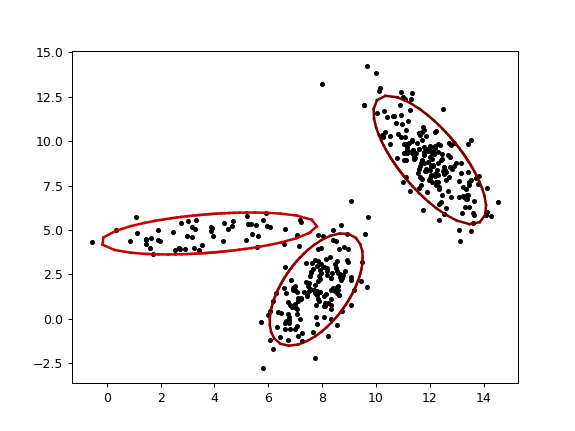

Likelihood for each iteration: [-5104.279264960514, -1928.1856022901711, -1893.3157804601333, -1872.6706940710378, -1854.7432007850348, -1833.3047313501238, -1796.3936321629744, -1710.0576683969389, -1601.8565838330517, -1595.7037079165116, -1595.6727188200582, -1595.670482001233, -1595.6703070601689, -1595.6702883799476, -1595.6702848593598, -1595.6702838632307, -1595.6702835403592, -1595.6702834323244, -1595.6702833959293, -1595.670283383651, -1595.670283379507, -1595.6702833781083, -1595.6702833776362, -1595.670283377477, -1595.6702833774232, -1595.670283377405, -1595.6702833773988, -1595.6702833773968, -1595.6702833773961, -1595.670283377396, -1595.670283377396]


In [141]:
#define number of components to estimate
nGaussEst = 3

#fit mixture of Gaussians (Pretend someone handed you some data. Now what?)
#TO DO fill in this routine (below)
mixGaussEst,iterations,likelihood_list = fitMixGauss(data,nGaussEst)

print("Likelihood for each iteration: " + str(likelihood_list))

The graph above represents the gaussian distributions we draw after the EM training. We are clearly observing that the distributions we obtained fit the ground true distributions satisfactory. Apart from that, we print the loglikelihood values for each iteration of out training prodedure. We observe that the likelihood value increases as the the number of iteration increases. 